### 1. Import Dependecies

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Tuple, Dict, List

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

### 2. PCA via Covariance Eigendecomposition

In [2]:
# Load data
df = pd.read_csv('../data/processed/CountryData_Preprocessed.csv')
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.274180,-1.759023,0.433342,0.147424,-1.408798,0.634392,-1.576856,1.729616,-1.455922
1,-0.238989,-0.283021,0.076251,0.290959,0.071445,-0.051222,0.628958,-0.941505,-0.122467
2,0.197869,0.183608,-0.981105,-0.497450,0.284385,1.160761,0.647886,0.143133,-0.064721
3,1.526599,0.905500,-1.804261,0.064940,-0.352198,1.495353,-1.093722,1.867087,-0.220645
4,-0.646536,0.435882,-0.123007,0.640302,0.603770,-0.916278,0.676185,-0.471103,0.606311


Steps to implement PCA:
1. Compute Covariance Matrix
2. Computer Eigen Values
3. Project data into principal components

In [3]:
def compute_pca_cov(X_std: np.ndarray, k: int = 4) -> Dict:
    n, m = X_std.shape 

    cov_matrix = np.cov(X_std.T)

    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix) 

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[idx]

    principal_components = eigenvectors[:, :k].T 

    scores = X_std @ principal_components.T 

    total_variance = np.sum(eigenvalues)
    explained_variance = eigenvalues[:k]
    explained_ratio = explained_variance / total_variance
    explained_cum = np.cumsum(explained_ratio)

    print(f"PCA via Covariance Matrix:")
    print(f"  Data shape: {X_std.shape}")
    print(f"  Components shape: {principal_components.shape}")
    print(f"  Scores shape: {scores.shape}")
    print(f"  Explained variance ratio (k={k}): {explained_ratio}")
    print(f"  Cumulative explained variance: {explained_cum}")
    
    return {
            'components': principal_components,
            'scores': scores,
            'eigenvalues': eigenvalues,
            'explained_variance': explained_variance,
            'explained_ratio': explained_ratio,
            'explained_cum': explained_cum,
            'total_variance': total_variance
            }

def top_loadings(components: np.ndarray, feature_names: List[str], top_n: int = 10) -> Dict:
    """
    Find top positive and negative loadings for each principal component.
    """
    results = {}

    for i, pc in enumerate(components):
        abs_loadings = np.abs(pc) # contribution == loadings
        top_indices = np.argsort(abs_loadings)[::-1][:top_n]

        pos_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] > 0]
        neg_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] < 0]

        results[f"PC{i+1}"] = {
                                'positive': pos_loadings,
                                'negative': neg_loadings
                                }

    return results


In [4]:
X_std = df.values
pca_cov_result = compute_pca_cov(X_std)
scores = pca_cov_result['scores']

PCA via Covariance Matrix:
  Data shape: (167, 9)
  Components shape: (4, 9)
  Scores shape: (167, 4)
  Explained variance ratio (k=4): [0.53830575 0.16821234 0.13547311 0.06659471]
  Cumulative explained variance: [0.53830575 0.7065181  0.84199121 0.90858592]


### 3. Visualization

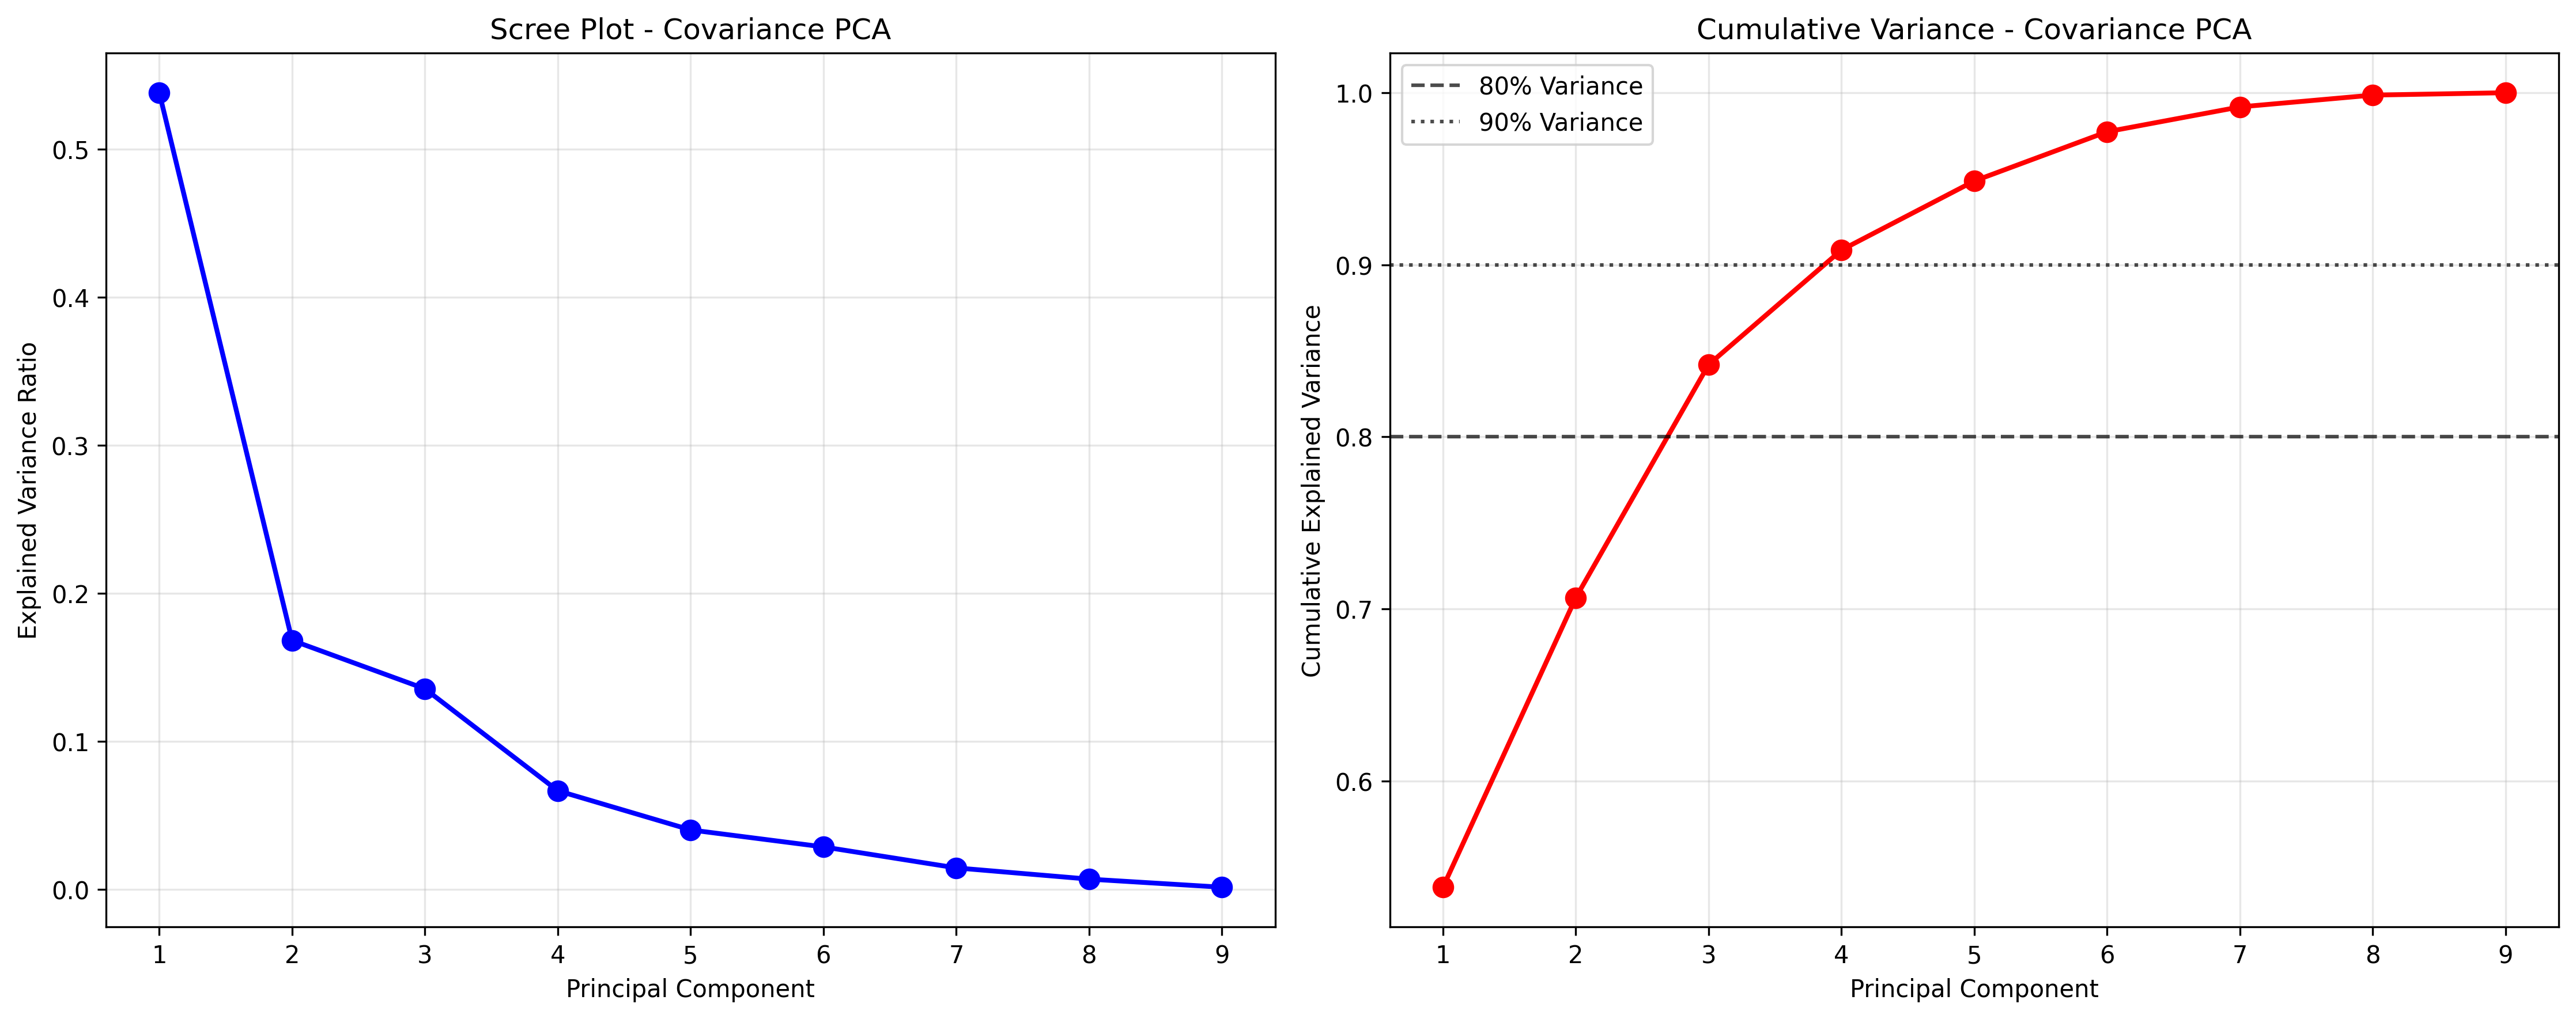

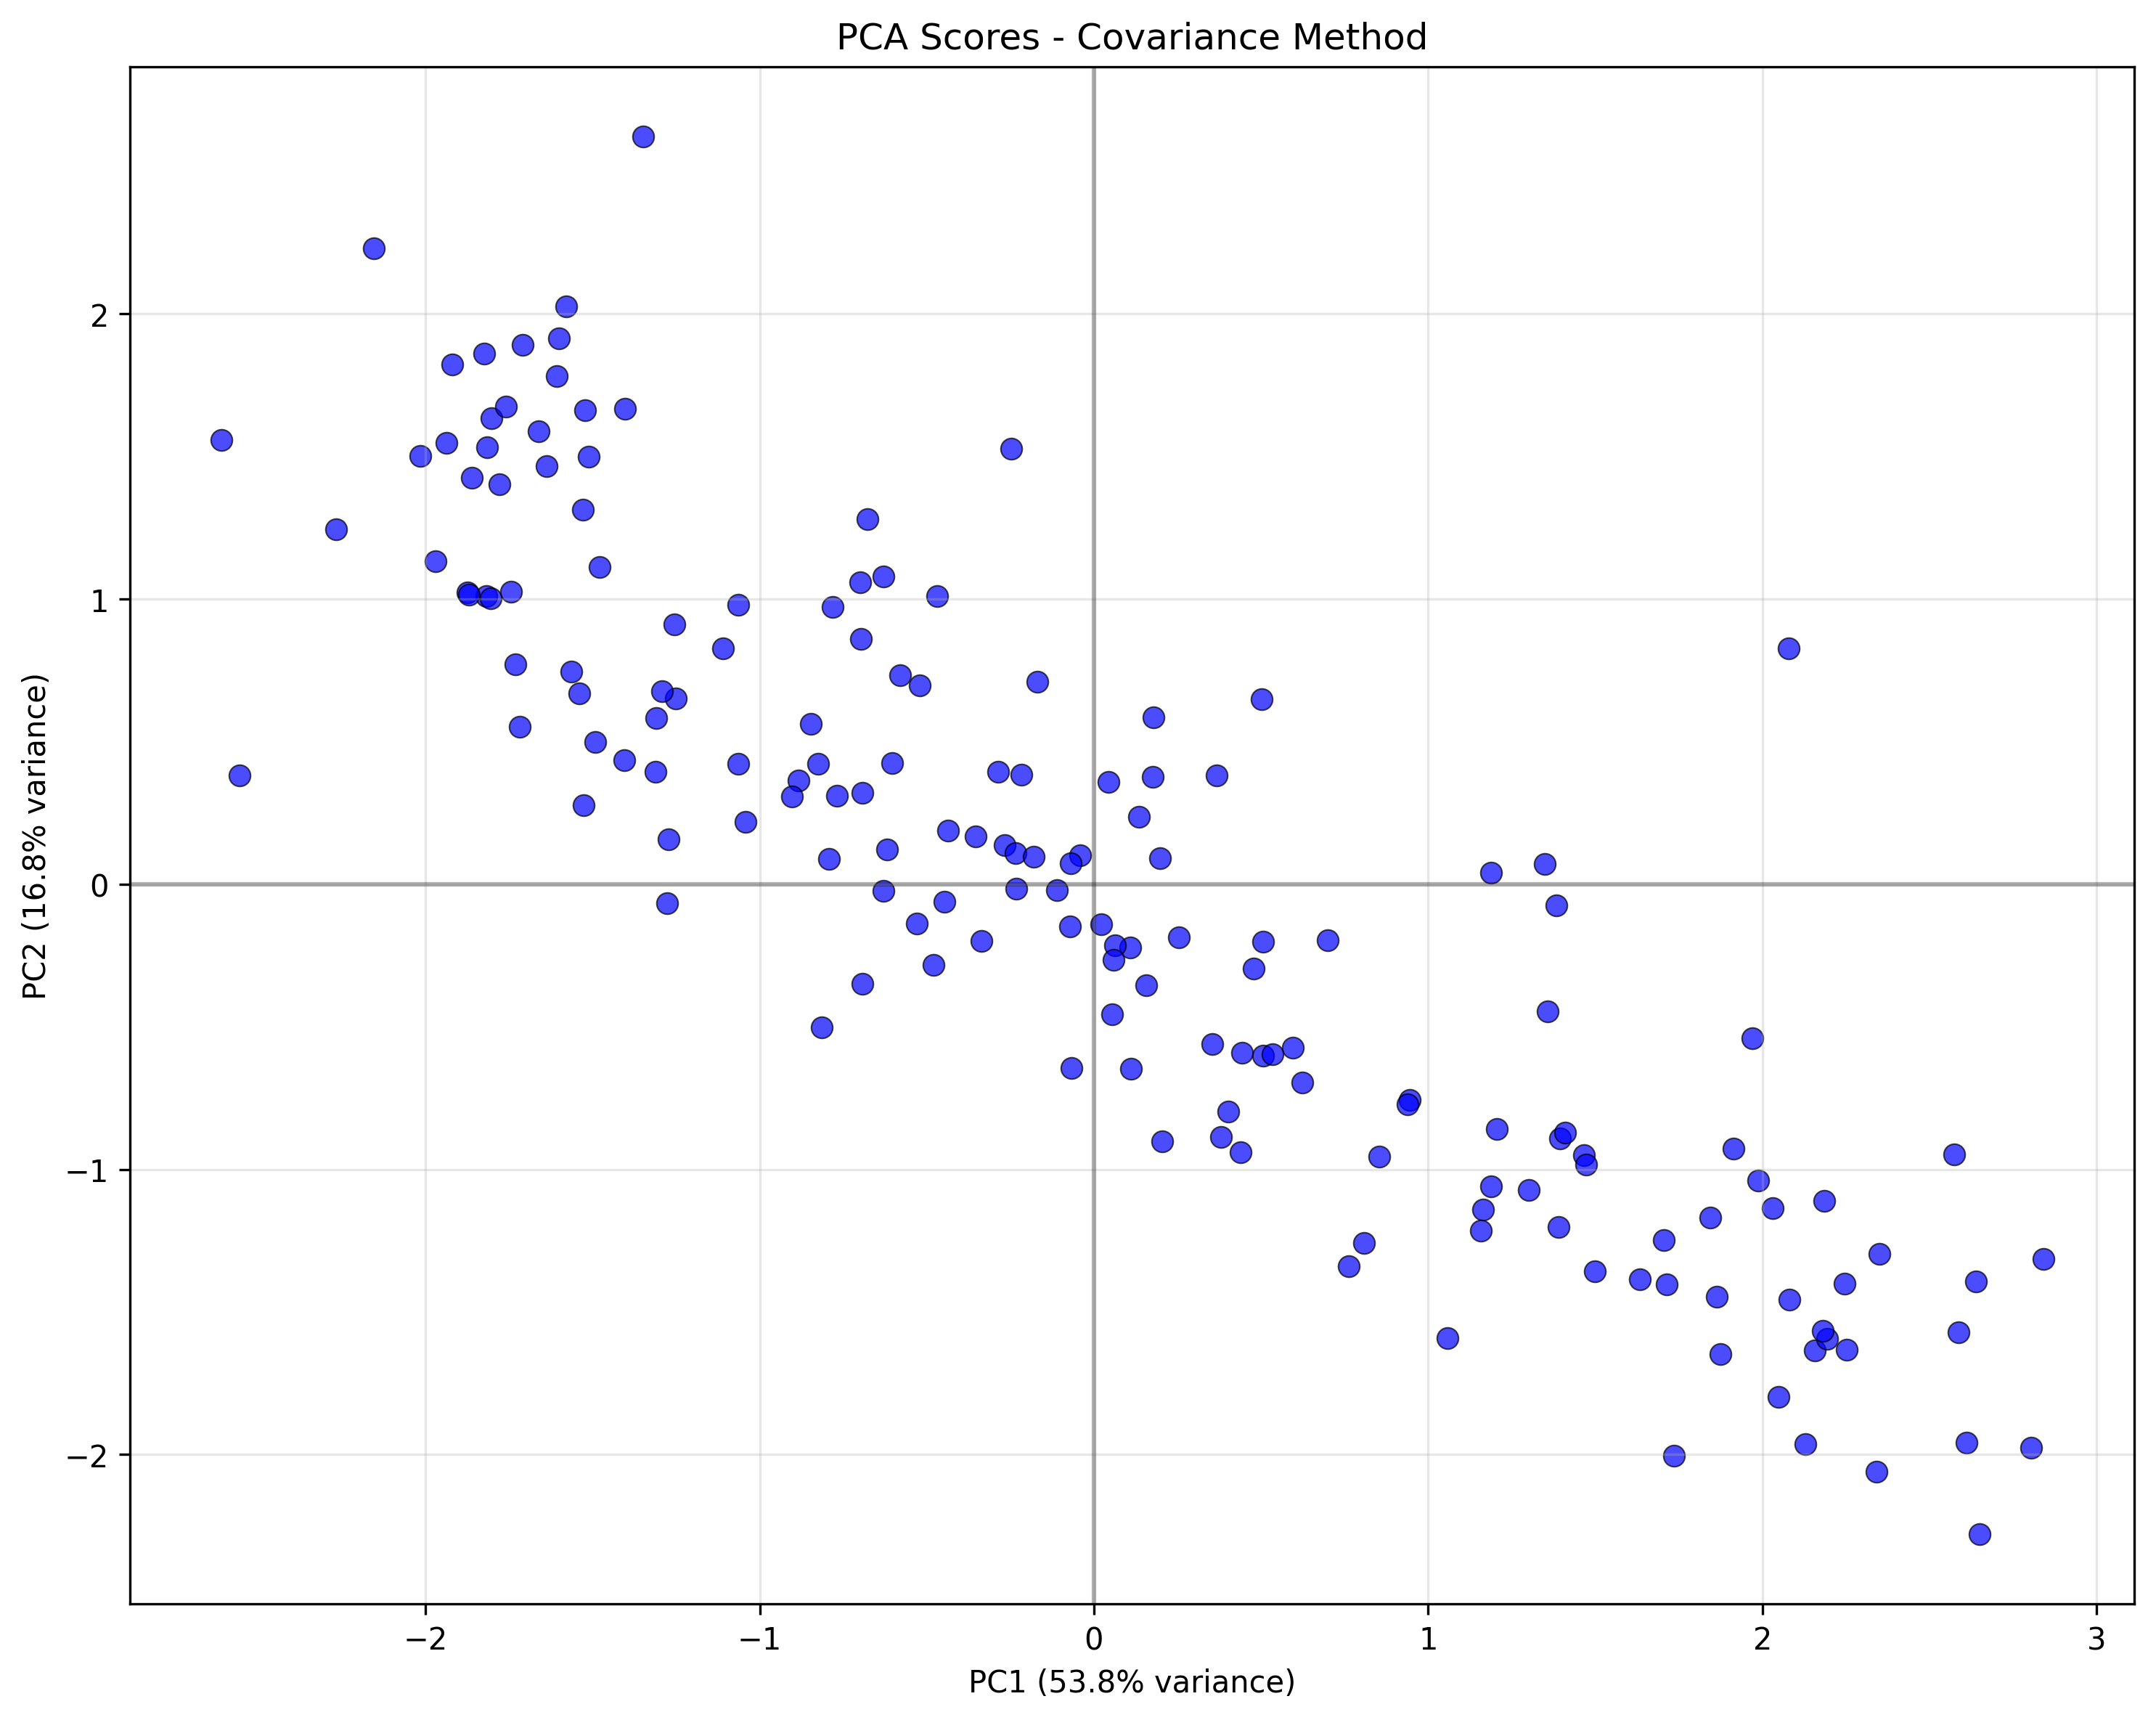

In [5]:
# Plot scree plot and cumulative variance for covariance PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree plot
eigenvals = pca_cov_result['eigenvalues']
explained_ratios = eigenvals / pca_cov_result['total_variance']
cumulative_ratios = np.cumsum(explained_ratios)

ax1.plot(range(1, len(eigenvals) + 1), explained_ratios, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Covariance PCA')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(eigenvals) + 1))

# Cumulative variance plot
ax2.plot(range(1, len(eigenvals) + 1), cumulative_ratios, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80% Variance')
ax2.axhline(y=0.9, color='k', linestyle=':', alpha=0.7, label='90% Variance')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance - Covariance PCA')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(range(1, len(eigenvals) + 1))

plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scree.png', dpi=300, bbox_inches='tight')
plt.show()

# 2D scatter plot of PC scores
plt.figure(figsize=(10, 8))
plt.scatter(pca_cov_result['scores'][:, 0], pca_cov_result['scores'][:, 1], 
           alpha=0.7, s=50, c='blue', edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca_cov_result["explained_ratio"][0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_cov_result["explained_ratio"][1]:.1%} variance)')
plt.title('PCA Scores - Covariance Method')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Saving new data set

In [6]:
df_pca = pd.DataFrame(scores, columns=[f'pc_{i+1}' for i in range(scores.shape[1])])
df_pca

,pc_1,pc_2,pc_3,pc_4
0,2.185959,-1.111385,0.313172,-0.786018
1,-0.266430,0.136436,-0.376817,-0.175182
2,-0.233323,-0.015875,-0.694483,-0.443121
3,1.205906,-0.857699,-0.851553,-0.436141
4,-0.883315,0.363755,0.384875,0.061058
...,...,...,...,...
162,0.853735,-0.956307,0.250331,0.026382
163,-0.630483,1.078182,-0.967664,-0.396893
164,0.204097,-0.902676,-1.193959,0.956974
165,0.938532,-0.771737,-0.499888,-0.266811


In [7]:
df_pca.to_csv('../data/processed/countries_pca_4components.csv', index=False)